## Setup

In [1]:
library(IRdisplay)
library(Cairo)

library(data.table)
library(arrow)
library(ggplot2)
library(cowplot)
library(ggrepel)
library(ggthemes)
library(ggpubr)
library(ggtext)
library(patchwork)
library(grid)
library(gridExtra)
library(scales)
library(stringr)
library(RColorBrewer)
library(yaml)
library(plyr)
library(tidyverse)
library(png)
library(rstatix)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘ggthemes’


The following object is masked from ‘package:cowplot’:

    theme_map



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots



Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()      masks plyr::arrange()
✖ dplyr::between()      masks data.table::between()
✖ readr::col_factor()   masks scales::col_factor()
✖ dplyr::combine()      masks gr

In [2]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)

In [3]:
output_path = '/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots'

In [4]:
# set global plot parameters
FONTSIZE = 12
THEME = theme_cowplot(font_size = FONTSIZE, font_family = 'Helvetica') + theme(plot.tag = element_text(face = "bold"))

In [5]:
eval_path = file.path('/s/project/promoter_prediction/kipoi_expression_prediction', 'evaluation/complete')
fname = paste0('prc_', 'tissue_type', '.parquet')
df = (file.path(eval_path, fname) %>%
      open_dataset(partitioning = c('run')) %>%
      as.data.table() %>%
      .[type_ == 'total'])
df = df[, .(tissue_type, run, score=auc)] %>% unique

In [6]:
runs = list(
    elasticnet=c('enformer_gtexv8_elasticnet_dnase_cage_logsumexp',
                 'enformer_gtexv8_elasticnet_dnase_cage_canonical',
                 'enformer_gtexv8_elasticnet_cage_canonical',
                 'enformer_gtexv8_elasticnet_cage_logsumexp',
                 'enformer_gtexv8_elasticnet_dnase_canonical',
                 'enformer_gtexv8_elasticnet_dnase_logsumexp',
                 'enformer_gtexv8_elasticnet_total_logsumexp',
                 'enformer_gtexv8_elasticnet_total_canonical'
                 ),
    tissue_mapper=c('enformer_gtexv8_elasticnet_cage_canonical',
                    'enformer_gtexv8_ridge_cage_canonical'),
    upstream=c('enformer_gtexv8_elasticnet_cage_canonical_2000_500',
               'enformer_gtexv8_elasticnet_cage_canonical_1600_500',
               'enformer_gtexv8_elasticnet_cage_canonical_1200_500',
               'enformer_gtexv8_elasticnet_cage_canonical_800_500',
               'enformer_gtexv8_elasticnet_cage_canonical_500_500',
               'enformer_gtexv8_elasticnet_cage_canonical_400_500',
               'enformer_gtexv8_elasticnet_cage_canonical_300_500',
               'enformer_gtexv8_elasticnet_cage_canonical_200_500',
               'enformer_gtexv8_elasticnet_cage_canonical_100_500',
               'enformer_gtexv8_elasticnet_cage_canonical_50_500'),
    downstream=c('enformer_gtexv8_elasticnet_cage_canonical_2000_500',
                 'enformer_gtexv8_elasticnet_cage_canonical_2000_400',
                 'enformer_gtexv8_elasticnet_cage_canonical_2000_300',
                 'enformer_gtexv8_elasticnet_cage_canonical_2000_200',
                 'enformer_gtexv8_elasticnet_cage_canonical_2000_100',
                 'enformer_gtexv8_elasticnet_cage_canonical_2000_50')
    )

In [7]:
superscript_mapping = c(
    `-` = '⁻',
    `+` = "", # ⁺
    `0` = "\u2070",
    `1` = "\u00B9",
    `2` = "\u00B2",
    `3` = "\u00B3",
    `4` = "\u2074",
    `5` = "\u2075",
    `6` = "\u2076",
    `7` = "\u2077",
    `8` = "\u2078",
    `9` = "\u2079"
)


In [8]:
fancy_scientific <- function(l, digits=NULL, low=1/1000, high=1000) {
    # turn in to character string in scientific notation
    l = as.numeric(l)
    if (is.na(l)) {
        return("NA")
    }
    if (l == 0) {
        return("0")
    }
    if ((low < l) & (l < high)){
        return(format(l, scientific=FALSE, digits=digits, big.mark=",", trim=TRUE))
    }
    l = format(l, scientific=TRUE, digits=digits)

    # l <- format(l, scientific = TRUE)
    # split into factor and exponent
    l_split = strsplit(l, 'e')[[1]]
    if (! is.null(digits)) {
        l_split[1] = round(as.numeric(l_split[1]), digits)
    }
    # make exponent superscript
    l_split[2] = as.numeric(l_split[2])
    l_split[2] = paste(
        lapply(strsplit(l_split[2], "")[[1]], function(x) noquote(superscript_mapping[[x]])),
        collapse=''
    )
    # concat everything
    l_split = paste0(l_split[1], "x10", l_split[2])

    l_split
}


In [9]:
boxplot_plot = function(df, title, ylim=NULL, is_y_percent=FALSE, pval_y_start=NULL, pval_y_end=NULL, show_pval=TRUE){
    df = copy(df)
    run_keys = levels(df$run)
    # find best run
    df[, median_score := median(score), by='run']
    df = df[order(-median_score)]
    # change order of run levels
    new_levels = df$run %>% unique %>% rev
    df[, run := factor(run, levels=new_levels)]
    best_run = df[1, run]

    # Wilcoxon test between best run and everything else
    comparisons = lapply(setdiff(run_keys, best_run), function(x) c(as.character(best_run), as.character(x)))

    stat.test <- (
        df
        %>% wilcox_test(`score` ~ `run`, paired=TRUE, comparisons=comparisons) 
        %>% add_significance("p")
    )
    

    # Add p-values to a boxplot
    stat.test <- stat.test %>% add_xy_position(x = "run") %>% arrange(xmin)
    stat.test$p_label = paste0(ifelse(stat.test$statistic == 0, "P < ", "P = "), lapply(stat.test$p, function(x) fancy_scientific(x, 1)))                     
    # print(as.data.table(stat.test))

    if (!is.null(pval_y_start) & !is.null(pval_y_end)){
        n = nrow(stat.test)
        stat.test$y.position = seq(pval_y_start, pval_y_end, length.out = n)
    }
    # print(as.data.table(stat.test))

    stat_label=if (show_pval) 'p_label' else 'p.signif'                                                                                    
                                                                                        
    p <- (
        ggplot(df, aes(y=`score`, x=`run`))
        + coord_flip(clip='off')
        + geom_boxplot(fill='grey')
        + scale_y_continuous(
            limits=if (is.null(ylim)) c(0, max(df[['score']]) * 2) else ylim,
            labels=if (is_y_percent) scales::percent else waiver()
        )
        + THEME
        + background_grid(major = "y")
        + theme(legend.title = element_blank())
        + theme(legend.position = "none")
        + labs(
            y=element_blank(),
            x=element_blank(),
        )
        + stat_pvalue_manual(stat.test, label = paste0('{', stat_label,'}'), coord.flip=TRUE)
        + background_grid()
    )
                                                                                    
                                                                                        
    return(p)
}                                                                                        

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <b8>”


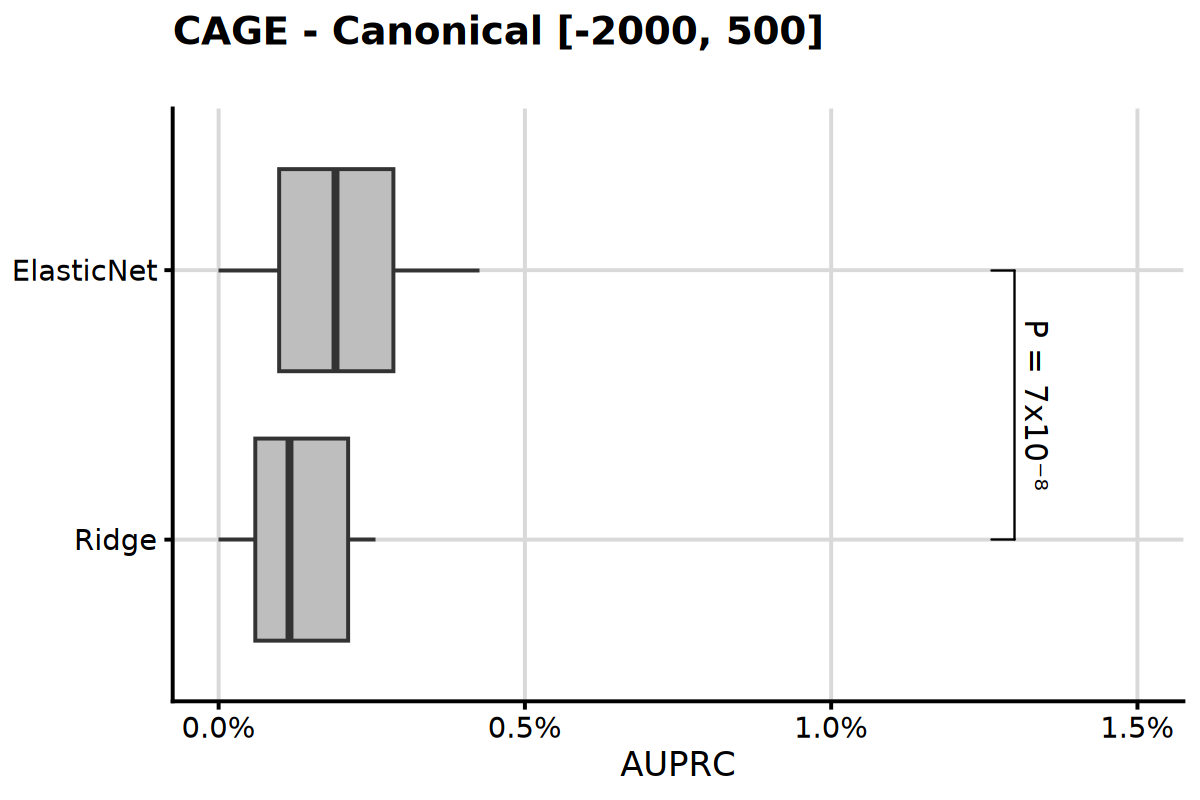

In [10]:
tissue_mapper_df = df[run %in% runs[['tissue_mapper']]] %>%
    .[, run := run %>% 
      str_replace('enformer_gtexv8_elasticnet_cage_canonical', 'ElasticNet') %>%
      str_replace('enformer_gtexv8_ridge_cage_canonical', 'Ridge')
     ]
tissue_mapper_df = tissue_mapper_df[, run := as.factor(run)]

p1 <- boxplot_plot(tissue_mapper_df, is_y_percent=TRUE,  pval_y_start=0.013, pval_y_end=0.013, ylim=c(0, 0.015)) + 
    labs(title='CAGE - Canonical [-2000, 500]', y='AUPRC') +
    theme(plot.title = element_text(margin = margin(0,0,20,0)))
p1

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁷' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁷' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁷' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁷' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁷' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁷' in 'mbcsToSbcs': dot substituted for <b7>”
Warning message 

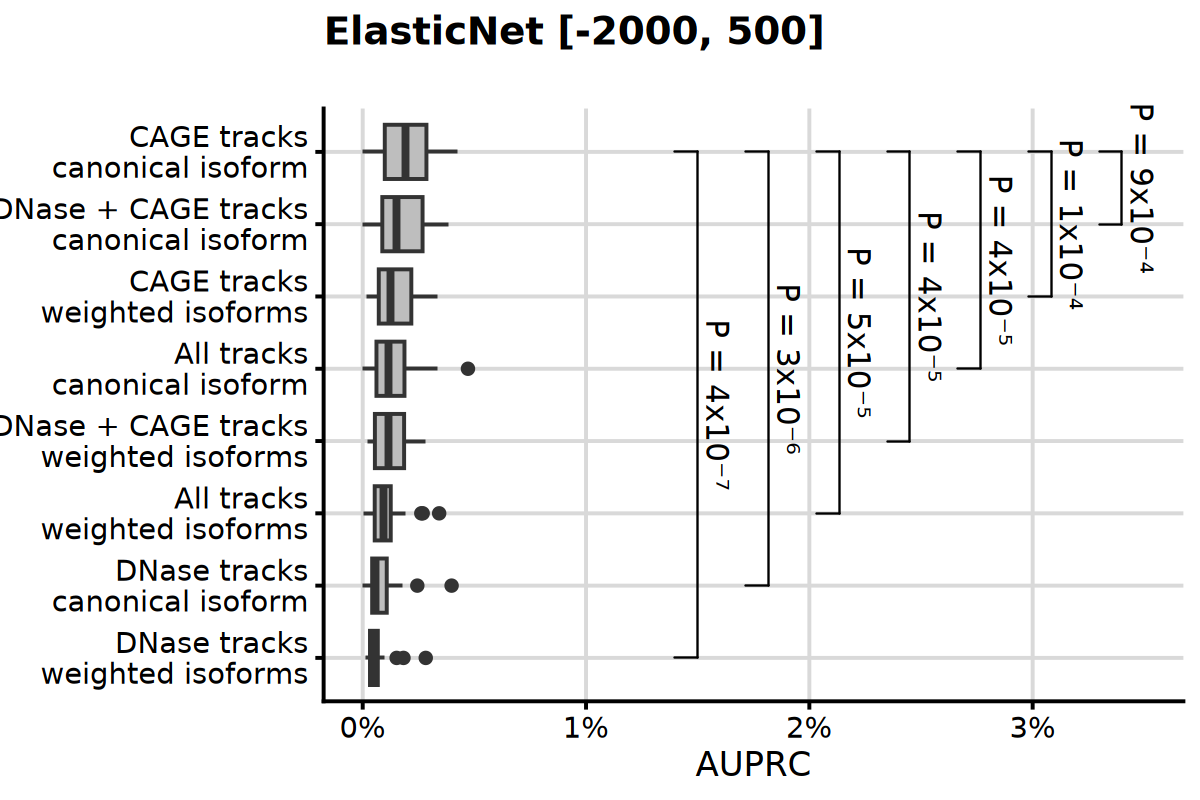

In [11]:
elasticnet_df = df[run %in% runs[['elasticnet']]] %>%
    .[, run := run %>% 
      str_replace('enformer_gtexv8_elasticnet_', '') %>%
      str_replace('dnase_cage', 'DNase + CAGE tracks') %>%
      str_replace('cage', 'CAGE tracks') %>%
      str_replace('dnase', 'DNase tracks') %>%
      str_replace('total', 'All tracks') %>%
      str_replace('_', '\n') %>%
      str_replace('canonical', 'canonical isoform') %>%
      str_replace('logsumexp', 'weighted isoforms')
     ]
elasticnet_df = elasticnet_df[, run := as.factor(run)]

p2 <- boxplot_plot(elasticnet_df, is_y_percent=TRUE, pval_y_start=0.015, pval_y_end=0.034, ylim=c(0, 0.035)) + 
    labs(title = 'ElasticNet [-2000, 500]', y='AUPRC') +
    theme(plot.title = element_text(margin = margin(0,0,20,0)))
p2

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁶' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁶' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁶' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁶' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁶' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁶' in 'mbcsToSbcs': dot substituted for <b6>”
Warning message 

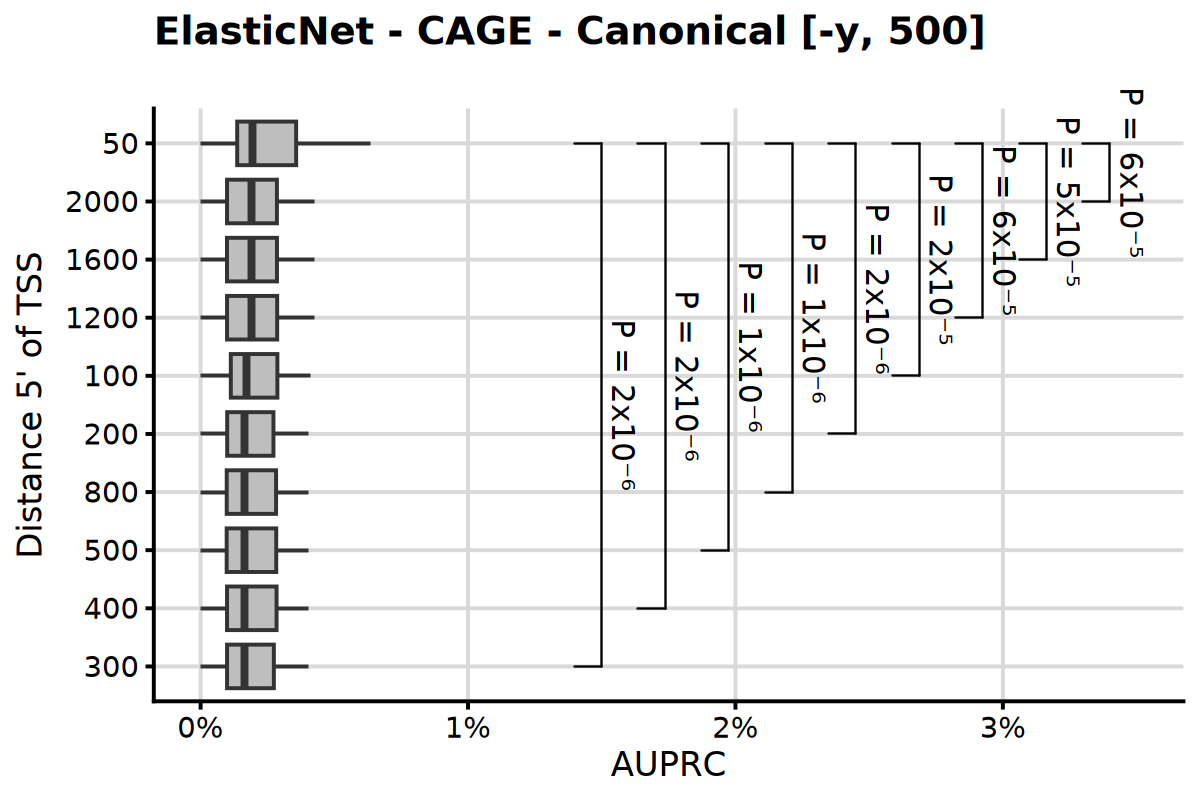

In [12]:
upstream_df = df[run %in% runs[['upstream']]] %>%
    .[, run := run %>% 
      str_replace('enformer_gtexv8_elasticnet_cage_canonical_', '') %>%
      str_replace('_500', '')
     ]
upstream_df = upstream_df[, run := as.factor(run)]

p3 <- boxplot_plot(upstream_df, is_y_percent=TRUE, pval_y_start=0.015, pval_y_end=0.034, ylim=c(0, 0.035)) + 
    labs(title= 'ElasticNet - CAGE - Canonical [-y, 500]',
         x="Distance 5' of TSS", y='AUPRC') +
    theme(plot.title = element_text(margin = margin(0,0,20,0)),
          axis.title.y = element_text(margin = margin(0,10,0,0)))
# +
#     theme(plot.title = element_text(margin = margin(0,0,20,0)))
p3

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁴' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁴' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁴' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁴' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁴' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁴' in 'mbcsToSbcs': dot substituted for <b4>”


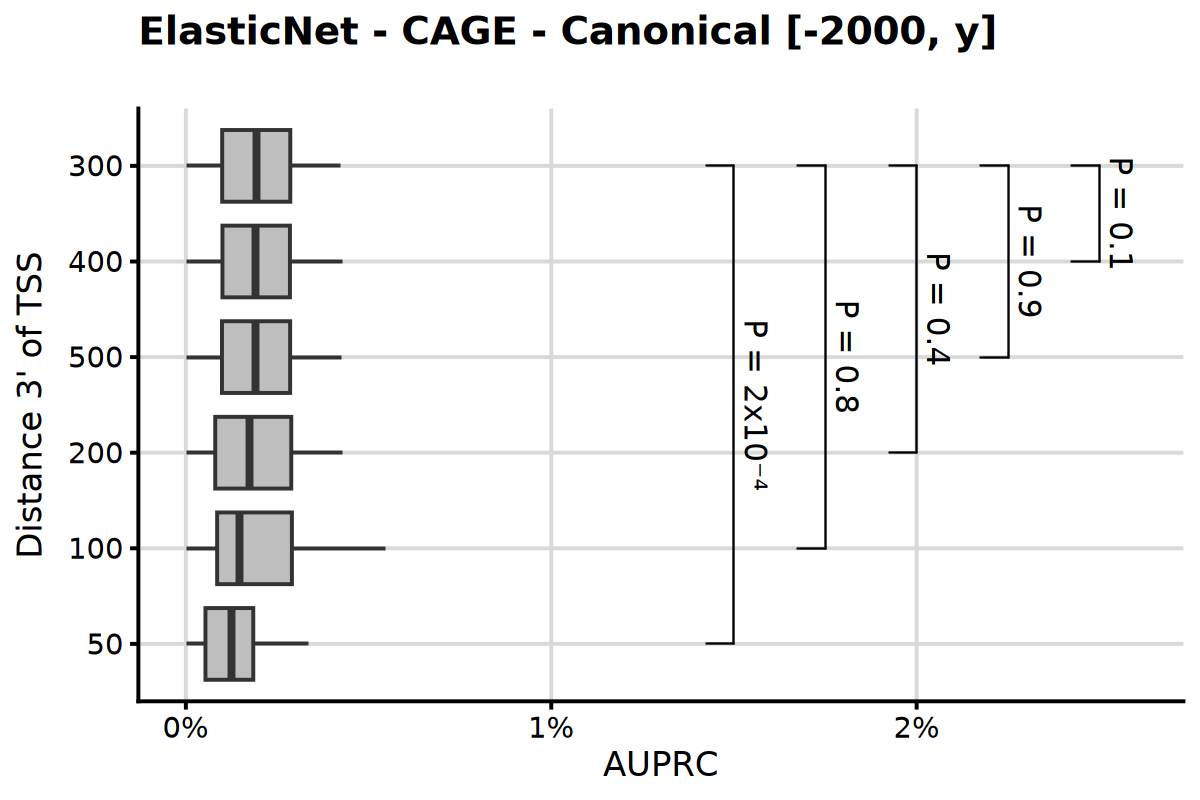

In [13]:
downstream_df = df[run %in% runs[['downstream']]] %>%
    .[, run := run %>% 
      str_replace('enformer_gtexv8_elasticnet_cage_canonical_', '') %>%
      str_replace('2000_', '')
     ]
downstream_df = downstream_df[, run := as.factor(run)]

p4 <- boxplot_plot(downstream_df, is_y_percent=TRUE, pval_y_start=0.015, pval_y_end=0.025, ylim=c(0, 0.026)) + 
    labs(title='ElasticNet - CAGE - Canonical [-2000, y]',
         x="Distance 3' of TSS", y='AUPRC') +
    theme(plot.title = element_text(margin = margin(0,0,20,0)),
          axis.title.y = element_text(margin = margin(0,10,0,0)))
p4

In [14]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.res=200)

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 7x10⁻⁸' in 'mbcsToSbcs': dot substituted for <b8>”
Warning message 

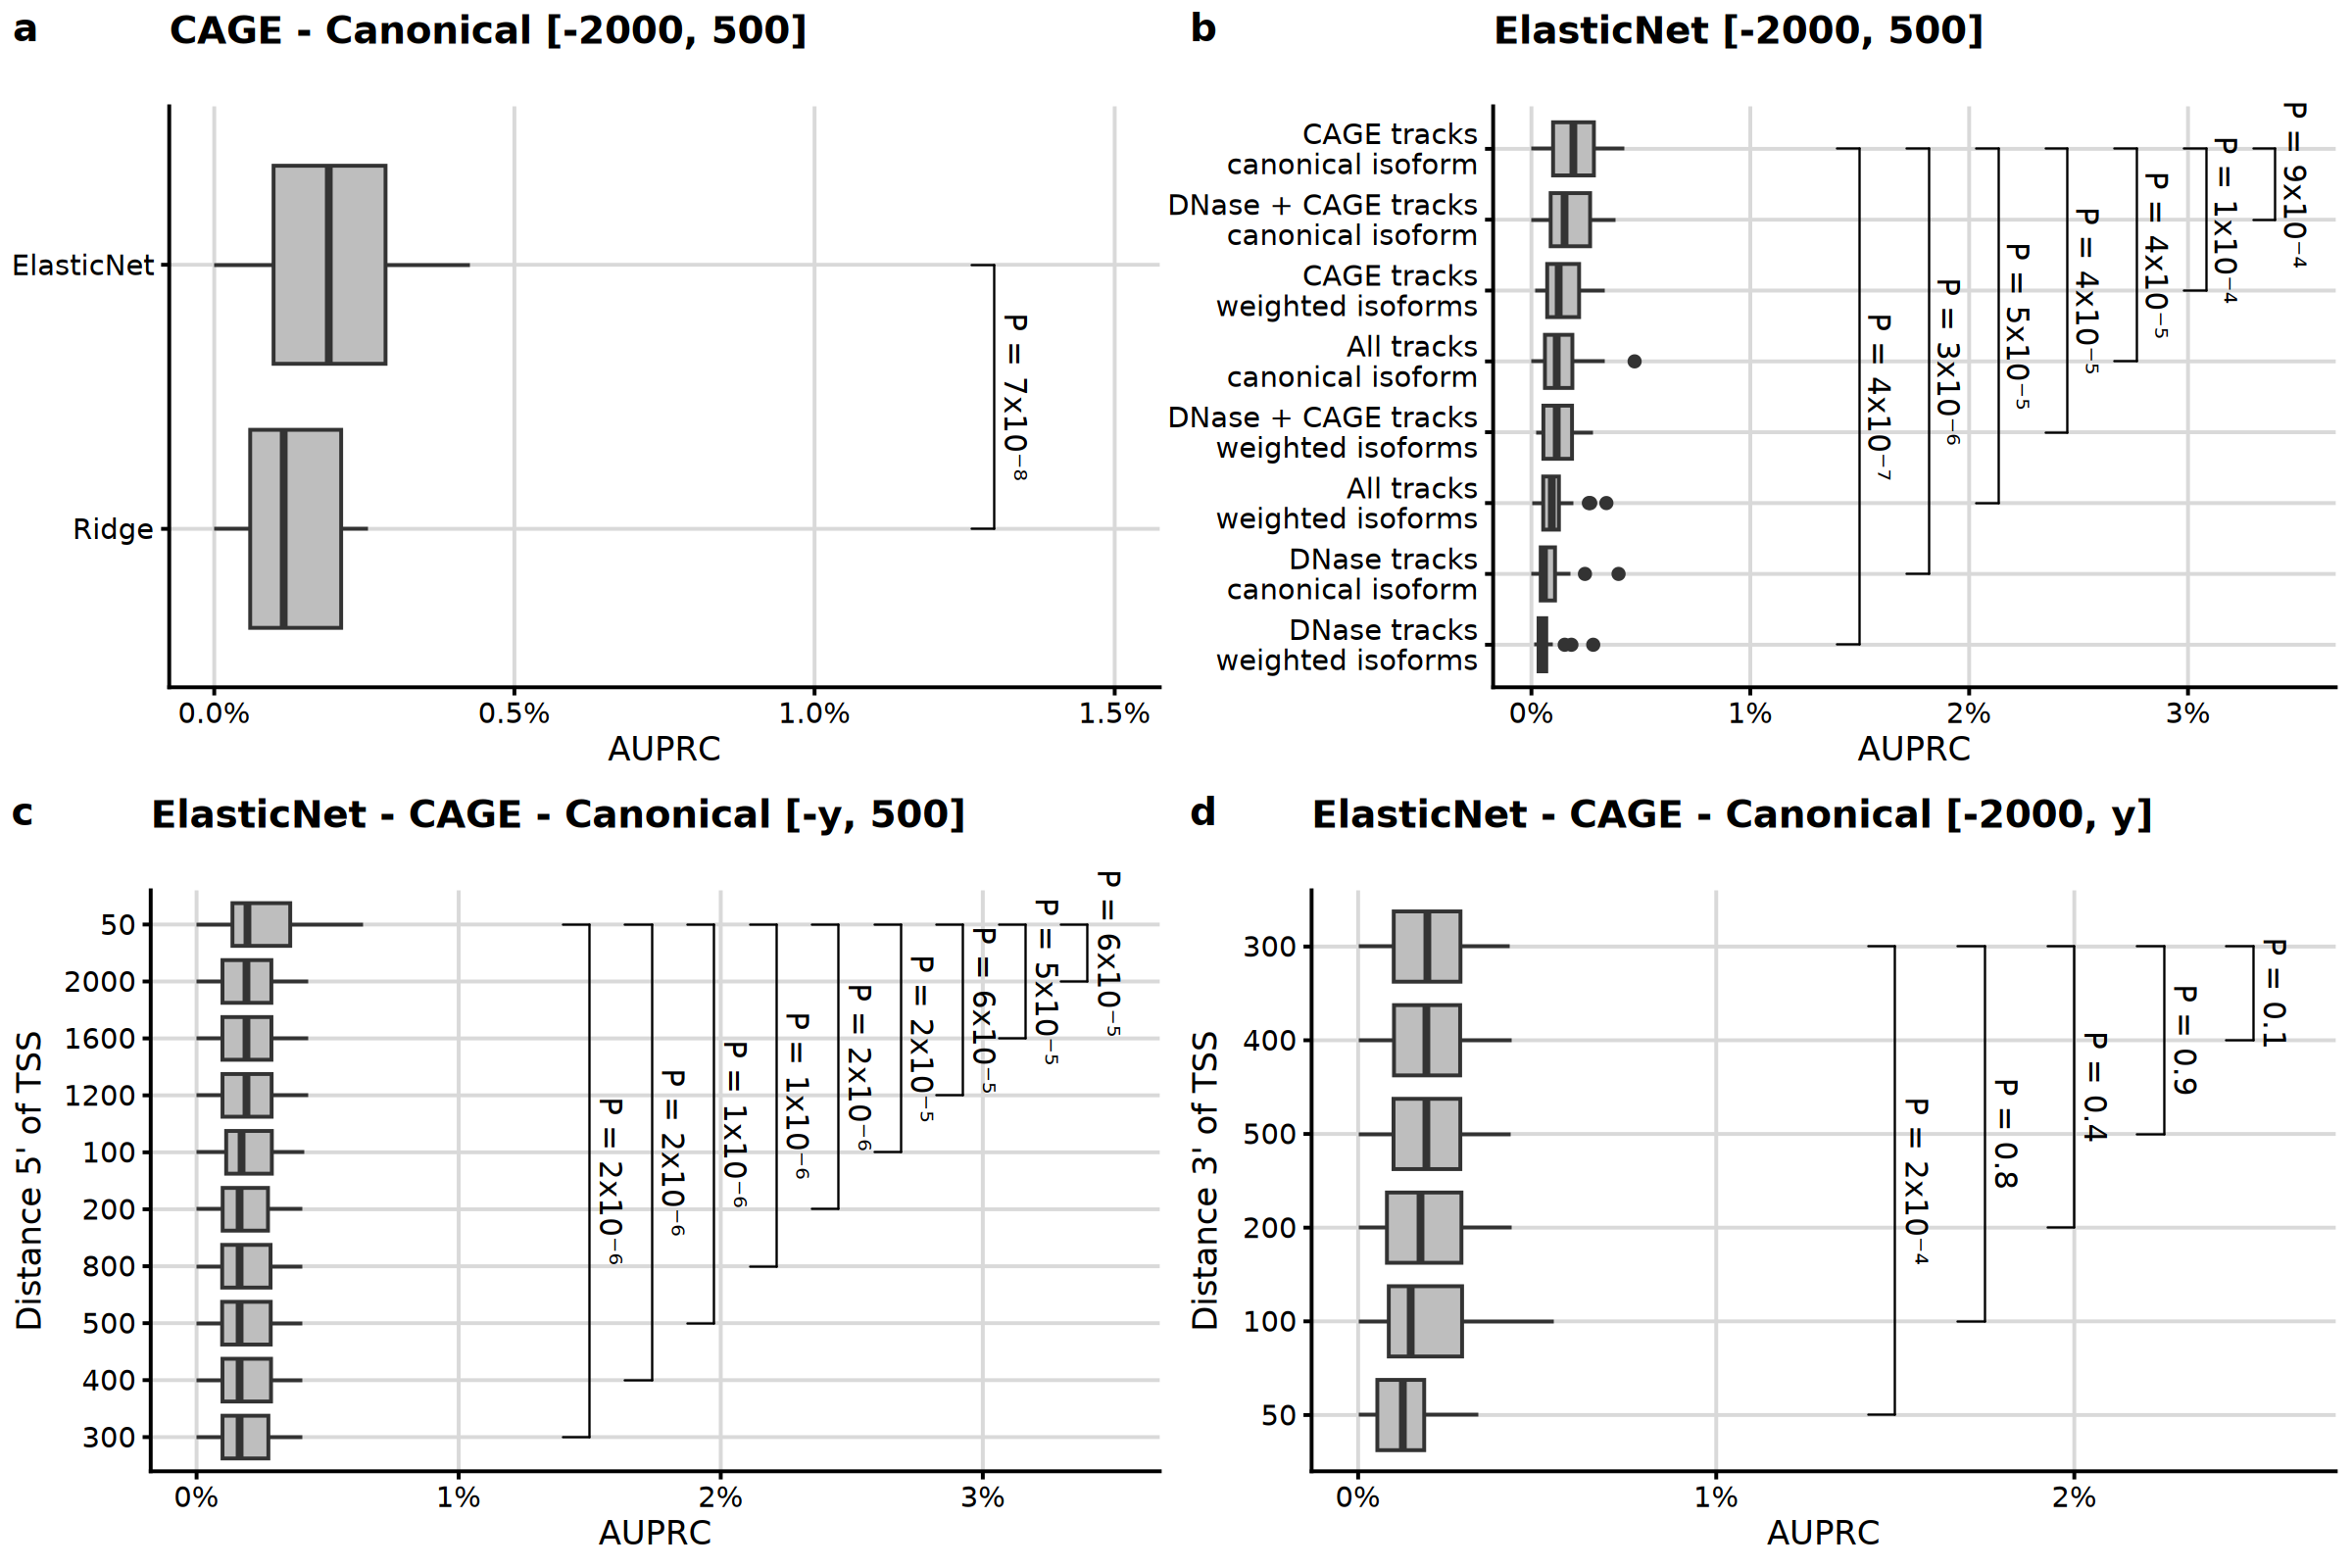

In [15]:
p5 = plot_grid(p1, p2, p3, p4, labels = c('a', 'b', 'c', 'd'))
p5

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/enformer_optimization..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”


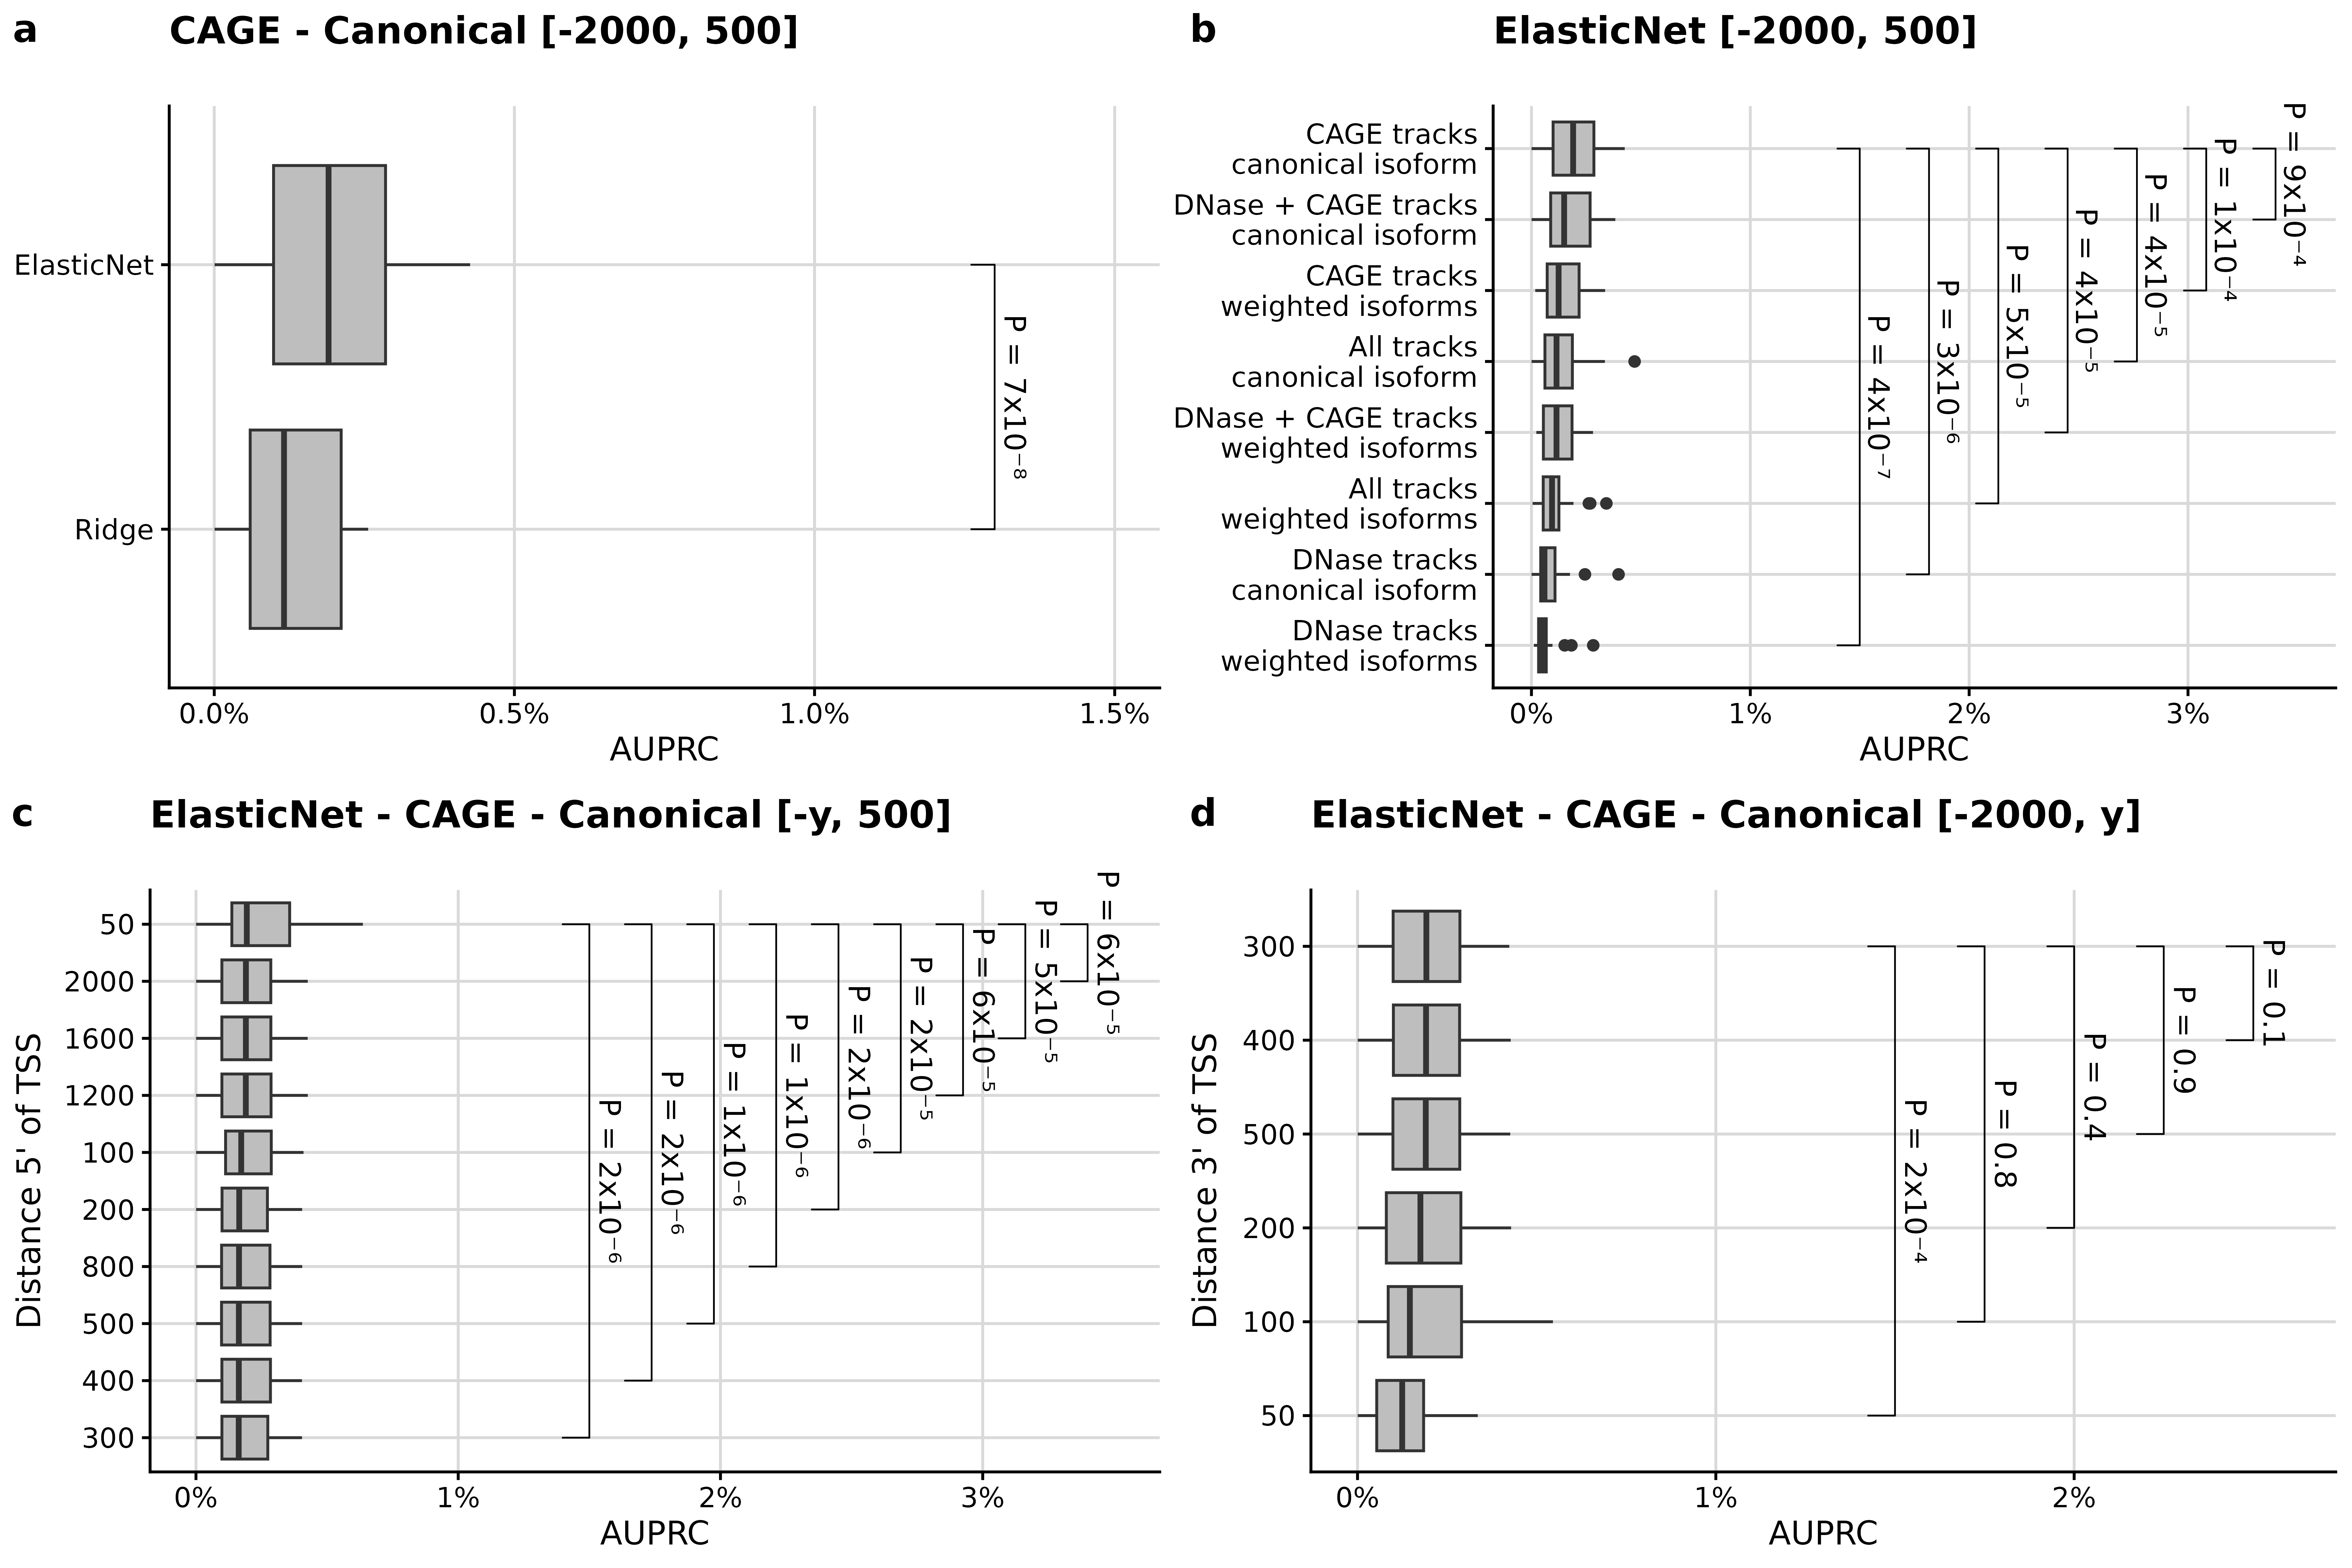

In [16]:
width=12
height=8

path = paste(output_path, 'enformer_optimization', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), bg = 'white', p5, width = width, height = height, dpi=600, type = "cairo")

display_png(file=paste0(path, ".png"))